In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

# CXR Modality-specific pretraining

## Import all the packages

In [2]:
import cv2
import os
import datetime
import time
import numpy as np

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing  import image_dataset_from_directory
from tensorflow.keras.layers import Input,UpSampling3D,Dense, Dropout,BatchNormalization 
from tensorflow.keras.layers import SeparableConv2D, Activation,DepthwiseConv2D,Flatten,concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Conv2DTranspose, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

Init Plugin
Init Graph Optimizer
Init Kernel


## Load the dataset

| Source|TB | NTB | NORM|
|-------|---|-----|------|
|NIH|4287|-|-|
|TBX11K|800|3800|3800|
|pediatric-pnemonia|-|4273|1575|
|**Total Training**|**5087**|**8073**|**5314**|
|Shenzhen|336|-|326|
|Montegomery|58|-|80|
|**Total**|||5394|


In [4]:
import glob
filename = glob.glob(r'./dataset/TBNTBN/train/TB/*.*')
print(len(filename))
filename = glob.glob(r'./dataset/TBNTBN/train/NTB/*.*')
print(len(filename))
filename = glob.glob(r'./dataset/TBNTBN/train/NORM/*.*')
print(len(filename))



5087
8065
5375


In [5]:
import glob
filename = glob.glob(r'./dataset/TBNTBN/test/TB/*.*')
print(len(filename))
filename = glob.glob(r'./dataset/TBNTBN/test/NTB/*.*')
print(len(filename))
filename = glob.glob(r'./dataset/TBNTBN/test/NORM/*.*')
print(len(filename))




58
390
245


In [6]:
BATCH_SIZE = 16
IMG_SIZE = (256, 256)

train_dir = './dataset/TBNTBN/train/'
test_dir = './dataset/TBNTBN/test/'

In [7]:
def create_dataset(img_folder):
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        i = 0
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread( image_path)
            if image is not None:
                image=cv2.resize(image, IMG_SIZE,interpolation = cv2.INTER_CUBIC)
                image=np.array(image)
                image = image.astype('float32')
#                 image /= 255 
                img_data_array.append(image)
                class_name.append(dir1)
            i += 1
            if i%500 == 0:
                print('loading {}th image for class {}'.format(i,str(dir1)))
    return np.array(img_data_array,np.float32), class_name


In [8]:
from sklearn.preprocessing import LabelBinarizer
train = LabelBinarizer()


In [9]:
train_data, train_y =create_dataset(train_dir)
target_val = train.fit_transform(train_y)



loading 500th image for class TB
loading 1000th image for class TB
loading 1500th image for class TB
loading 2000th image for class TB
loading 2500th image for class TB
loading 3000th image for class TB
loading 3500th image for class TB
loading 4000th image for class TB
loading 4500th image for class TB
loading 5000th image for class TB
loading 500th image for class NTB
loading 1000th image for class NTB
loading 1500th image for class NTB
loading 2000th image for class NTB
loading 2500th image for class NTB
loading 3000th image for class NTB
loading 3500th image for class NTB
loading 4000th image for class NTB
loading 4500th image for class NTB
loading 5000th image for class NTB
loading 5500th image for class NTB
loading 6000th image for class NTB
loading 6500th image for class NTB
loading 7000th image for class NTB
loading 7500th image for class NTB
loading 8000th image for class NTB
loading 500th image for class NORM
loading 1000th image for class NORM
loading 1500th image for class 

In [10]:
# test = LabelBinarizer()
# X_test,y_test = create_dataset(test_dir)
# y_test = test.fit_transform(y_test)
# X_test = np.array(X_test,)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(train_data, ), 
                                                    target_val, 
                                                    test_size=0.10,
                                                    random_state=42)



In [12]:
def build_model(input_shape):
    inputs = Input(shape=input_shape, name="input_image")
    mobilenetv2 = tf.keras.applications.MobileNetV2(
        input_tensor = inputs, 
        weights="imagenet", include_top=False, alpha=0.35)
    
    x = mobilenetv2.get_layer('out_relu').output
    x = GlobalAveragePooling2D(name='gap')(x)
    output = Dense(3,activation='softmax')(x)
    return tf.keras.Model(inputs,output)


In [13]:
model = build_model(input_shape=(256,256,3))
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
model.summary() 

Metal device set to: Apple M1


2022-08-15 18:34:24.568317: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-15 18:34:24.569063: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 16) 432         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 16) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [14]:
# tf.keras.utils.plot_model(model, "without_sincnet.png", show_shapes=True)

In [15]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# callback = [
#     tf.keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.1, patience=3, verbose=1, min_lr=1e-8 ),
#     tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
#     tf.keras.callbacks.ModelCheckpoint(
#         filepath='../../output/checkpoints/mobilenetv2/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
#         save_best_only=True,save_weights_only=True,verbose=1)
#            ]

In [16]:
history = model.fit(x=X_train, 
                    y = y_train,
                    validation_split=0.1,
                    epochs=15,
                    batch_size = 16,
                              )
#                    callbacks=callback)


2022-08-15 18:34:25.532207: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-15 18:34:25.535912: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/15


2022-08-15 18:34:26.467895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - ETA: 0s - loss: 0.1946 - accuracy: 0.9326

2022-08-15 18:36:59.937519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 159s 168ms/step - loss: 0.1946 - accuracy: 0.9326 - val_loss: 0.3710 - val_accuracy: 0.8471
Epoch 2/15
938/938 [==============================] - 159s 170ms/step - loss: 0.0776 - accuracy: 0.9738 - val_loss: 0.0852 - val_accuracy: 0.9748
Epoch 3/15
938/938 [==============================] - 156s 166ms/step - loss: 0.0500 - accuracy: 0.9833 - val_loss: 0.1135 - val_accuracy: 0.9634
Epoch 4/15
938/938 [==============================] - 157s 167ms/step - loss: 0.0390 - accuracy: 0.9872 - val_loss: 0.0757 - val_accuracy: 0.9778
Epoch 5/15
938/938 [==============================] - 166s 177ms/step - loss: 0.0263 - accuracy: 0.9915 - val_loss: 0.0632 - val_accuracy: 0.9790
Epoch 6/15
938/938 [==============================] - 159s 170ms/step - loss: 0.0226 - accuracy: 0.9929 - val_loss: 0.0609 - val_accuracy: 0.9844
Epoch 7/15
938/938 [==============================] - 157s 167ms/step - loss: 0.0174 - accuracy: 0.9939 - val_loss: 0.0590 - val_accura

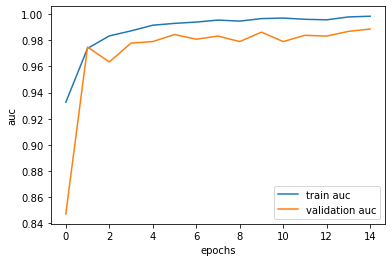

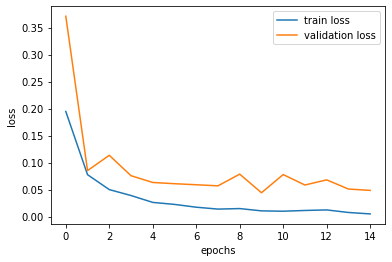

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train auc','validation auc'])
plt.ylabel('auc')
plt.xlabel('epochs')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history[ 'val_loss'])
plt.legend(['train loss','validation loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()


In [18]:
# model = build_model(input_shape=(256,256,3))
# model.load_weights('output/weights.22-0.06.hdf5')
# model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
#                          loss='binary_crossentropy',
#                          metrics=['accuracy'])


In [19]:
model.evaluate(X_test,y_test)



58/58 [==============================] - 6s 88ms/step - loss: 0.0676 - accuracy: 0.9827


[0.06759814918041229, 0.9827306866645813]

In [20]:
predictions = model.predict(X_test)
# predictions = predictions.reshape(138,3)


2022-08-15 19:13:50.283131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [21]:
predictions

array([[4.7112856e-09, 1.0000000e+00, 1.5375695e-08],
       [9.9999833e-01, 1.5633860e-06, 6.3101851e-08],
       [2.7388548e-08, 9.9999678e-01, 3.2174426e-06],
       ...,
       [2.4937788e-14, 3.8766887e-09, 1.0000000e+00],
       [1.5349415e-10, 1.0000000e+00, 2.1502665e-08],
       [1.6540007e-07, 9.9999976e-01, 9.3377565e-08]], dtype=float32)

In [22]:
pred = np.zeros((y_test.shape[0]))
for i,p in enumerate(predictions):
    l = np.argmax(p)
    pred[i] = l
    

In [23]:
# predictions = [int(xx[0]<xx[1]) for xx in predictions]
y = [np.argmax(yy) for yy in y_test]


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y,pred))


              precision    recall  f1-score   support

           0       0.98      0.97      0.98       522
           1       0.98      0.98      0.98       858
           2       0.98      1.00      0.99       473

    accuracy                           0.98      1853
   macro avg       0.98      0.98      0.98      1853
weighted avg       0.98      0.98      0.98      1853



In [25]:
import pandas as pd
df = pd.DataFrame({'ytrue':y,'pred':pred})
print(df['ytrue'].value_counts())
print(df['pred'].value_counts())


1    858
0    522
2    473
Name: ytrue, dtype: int64
1.0    856
0.0    517
2.0    480
Name: pred, dtype: int64


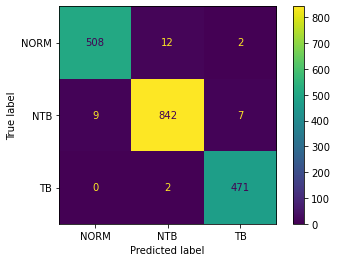

In [26]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y,pred,labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['NORM','NTB','TB'])
disp.plot()
plt.show()


In [27]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_cam_heatmap(img_array,model, layer_name,cam_path="cam.jpg"):
    
        #Get the 128 input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]

        get_output = K.function(
            [model.input], 
            [model.get_layer(layer_name).output, model.output])
        
        [conv_outputs, predictions] = get_output([img_array])
        conv_outputs = conv_outputs[0, :, :, :]
        
        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
        
        for i,w in enumerate(class_weights[:, 0]):
            cam += w * conv_outputs[:, :, i]
            
        cam = tf.maximum(cam, 0) / tf.math.reduce_max(cam)

        return cam.numpy()

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    grads=grads[0,:,:,:]

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.math.multiply(last_conv_layer_output,grads)
    heatmap = tf.reduce_sum(heatmap,axis=-1)
#     heatmap = tf.keras.layers.Sigmoid()(heatmap)

    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [28]:
def save_and_display_gradcam(img, heatmap, pos, cam_path="cam.jpg", alpha=0.4,title='input'):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:,:3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    plt.subplot(10,2,pos)
    plt.title(title)
    plt.imshow(superimposed_img)



In [29]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [30]:
# model = build_model(input_shape=(256,256,3))
# model.load_weights('../../output/checkpoints/mobilenetv2/weights.22-0.06.hdf5')
# model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
#                          loss='binary_crossentropy',
#                          metrics=['accuracy'])



1 [5.9944361e-10 2.1810443e-07 9.9999976e-01]
2 [2.7857097e-09 9.9999988e-01 6.1747521e-08]
3 [9.7191560e-12 1.1664517e-10 1.0000000e+00]
4 [8.778361e-09 1.000000e+00 3.954931e-08]
5 [3.2333847e-11 9.9999988e-01 6.8711167e-08]
6 [1.0778685e-07 9.9999988e-01 1.2541221e-11]
7 [2.2035618e-08 9.9999976e-01 2.2960316e-07]
8 [9.9998760e-01 6.9682760e-06 5.5247733e-06]
9 [2.4728113e-08 9.9998498e-01 1.5020737e-05]
10 [9.785607e-10 7.172491e-08 9.999999e-01]


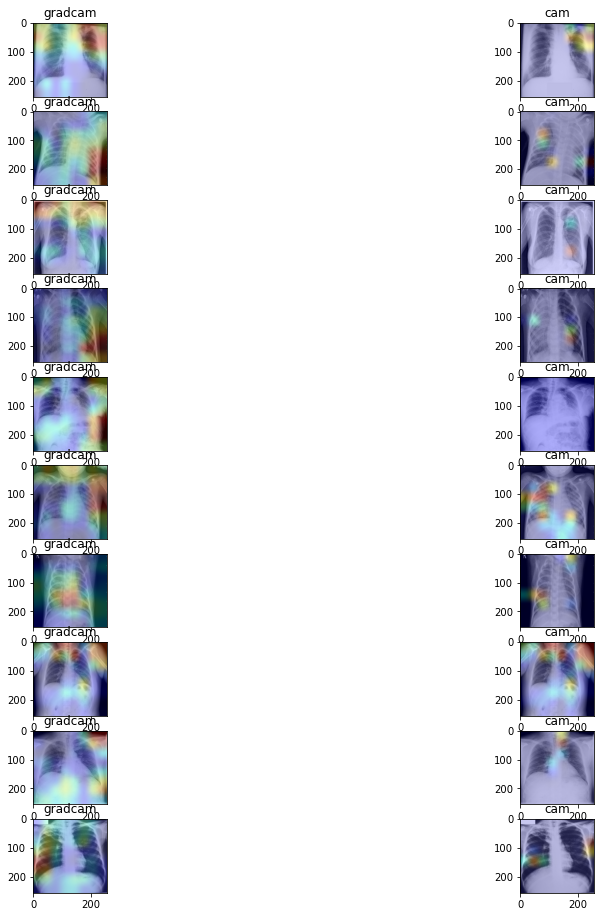

In [31]:
plt.figure(figsize=(16, 16))

for count in range(1,11):#(len(filename)):
#     im = cv2.imread(filename[count])
#     im = cv2.resize(im, (256,256), interpolation = cv2.INTER_AREA)
#     img = tf.keras.preprocessing.image.load_img(
#         filename[count],
#         color_mode='rgb', 
#         target_size=(256, 256))
#     img = tf.keras.preprocessing.image.img_to_array(img)
    img = X_test[count+10]
    im = img
    img = np.reshape(img,(1,256,256,3))
    print(count,max(model.predict(img)))
   
    heatmap_cam = make_cam_heatmap(img, model, 'out_relu')
    heatmap_gradcam = make_gradcam_heatmap(img, model, 'out_relu')
    save_and_display_gradcam(im, heatmap_gradcam,2*count-1,title='gradcam')
    save_and_display_gradcam(im, heatmap_cam,2*count,title='cam')
    

2022-08-15 19:13:57.997693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


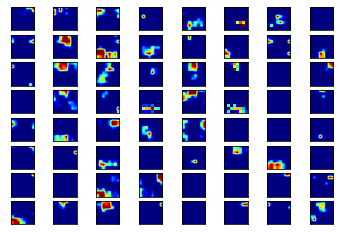

In [32]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import Model

layer_dict = dict([(layer.name, layer) for layer in model.layers])

layer_name = 'out_relu'

mdl = Model(inputs=model.inputs, outputs=layer_dict[layer_name].output)

# Perpare the image
image = load_img(filename[1], target_size=(256, 256))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
# image = preprocess_input(image)

# Apply the model to the image
feature_maps = mdl.predict(image)

square = 8
index = 1
for _ in range(square):
    for _ in range(square):
        
        ax = plt.subplot(square, square, index)
        ax.set_xticks([])
        ax.set_yticks([])

        plt.imshow(feature_maps[0, :, :, index-1], cmap='jet')
        index += 1
        
plt.show()